In [1]:
import atmospy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import os

# disable warnings for demo purposes
warnings.filterwarnings("ignore")

atmospy.set_theme()

# this tutorial was completed using version:
atmospy.__version__

'0.1.2'

In [2]:
# Initialize an empty DataFrame
df_lcs = pd.DataFrame()

# Define the start and end months and years
start_month = 11
start_year = 2023
end_month = 2
end_year = 2024

# Function to generate month-year strings
def generate_month_year_strings(start_month, start_year, end_month, end_year):
    month_year_list = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        month_year_list.append(f"{year}_{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return month_year_list

# Generate the list of month-year strings
month_year_strings = generate_month_year_strings(start_month, start_year, end_month, end_year)

# Loop through each month-year string and load the CSV files
for month_year_string in month_year_strings:
    year, month = month_year_string.split('_')
    filename_tail = f"@devnode_{year}-{month}.csv"
    directory = os.path.join("lcs_data", month_year_string)

    df_co = pd.read_csv(os.path.join(directory, f"raw_CO-B4{filename_tail}"), sep=',')
    df_pm_opcn3 = pd.read_csv(os.path.join(directory, f"raw_PM-OPCN3{filename_tail}"), sep=',')
    df_pm_sps30 = pd.read_csv(os.path.join(directory, f"raw_PM-SPS30{filename_tail}"), sep=',')
    df_trh = pd.read_csv(os.path.join(directory, f"raw_T_RH_P_BME280{filename_tail}"), sep=',')
 
    # Combining all datasets using the "Čas" column
    df_temp = pd.merge(df_co, df_trh, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_sps30, on="Čas")
    
    # Calculating actual values for the WE (working electrode) and AE (auxiliary electrode) values
    df_temp["CO"] = df_temp["WE_CO"] - df_temp["AE_CO"]
      
    # Dropping the extra columns (including the pressure - that makes a negligible difference)
    df_temp = df_temp.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)
    
    # Renaming the "Čas" column
    df_temp = df_temp.rename(columns={'Čas': 'Time'})
    
    # Converting the time to a datetime
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    
    # 1h shift of the CSV data (CSV seems to be UTC+1, reference data UTC)
    df_temp['Time'] += pd.Timedelta(hours=1)
    
    # Set 'Time' column as the DataFrame index
    df_temp.set_index('Time', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean for each group
    df_temp_1h = df_temp.resample('1h').mean()
    
    # Assign the calculated hourly means back to the original DataFrame
    df_temp = df_temp_1h.reset_index()
    
    # Append the data to the main DataFrame
    df_lcs = pd.concat([df_lcs, df_temp], ignore_index=True)

# Renaming the "Time" column to "GMT"
df_lcs = df_lcs.rename(columns={'Time': 'GMT'})

# Set 'GMT' column as the DataFrame index
df_lcs.set_index('GMT', inplace=True)

# Print the data types of the final DataFrame
print(df_lcs.dtypes)

T          float64
RH         float64
p          float64
PM_1_x     float64
PM_2.5     float64
PM_10_x    float64
PM_1_y     float64
PM_2       float64
PM_10_y    float64
CO         float64
dtype: object


In [3]:
# The edited dataset has the "Celkem" values at the end of the data removed
#df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")
df_ref = pd.DataFrame()

df_ref = pd.read_csv('gmt_data/Nov-Feb_GMT_MarHory.csv', sep=';')
#df_ref = pd.read_csv('gmt_data/Mar-Jul_GMT_MarHory.csv', sep=';')

#df_ref = df_ref.rename(columns={
#        'Unnamed: 0': 'Time',
#        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
#        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
#        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
#        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
#        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
#        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
#        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
#        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
#        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
#})

#Apply the function to the entire column
df_ref['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_ref['GMT'] = df_ref['GMT'].dt.tz_localize('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_ref = df_ref.drop(["TIME"], axis=1)

# Pokud potřebujete změnit pouze určité sloupce, můžete specifikovat sloupce takto:

df_ref[['WDIR [deg]', 
        'HUMI [%]', 
        'PRES [hPa]', 
        'TEMP [°C]', 
        'PM10 [ug/m3]', 
        'PM25 [ug/m3]', 
        'PM01 [ug/m3]', 
        'O3 [ug/m3]', 
        'SO2 [ug/m3]', 
        'NO [ug/m3]', 
        'NO2 [ug/m3]', 
        'CO [ug/m3]']] = df_ref[['WDIR [deg]', 
                                 'HUMI [%]', 
                                 'PRES [hPa]', 
                                 'TEMP [°C]', 
                                 'PM10 [ug/m3]', 
                                 'PM25 [ug/m3]', 
                                 'PM01 [ug/m3]', 
                                 'O3 [ug/m3]', 
                                 'SO2 [ug/m3]', 
                                 'NO [ug/m3]', 
                                 'NO2 [ug/m3]', 
                                 'CO [ug/m3]']].astype('float64')

#df_ref.head()
#print(df_ref.describe())
print(df_ref.dtypes)

GMT             datetime64[ns, UTC]
WSPE [m/s]                  float64
WDIR [deg]                  float64
HUMI [%]                    float64
PRES [hPa]                  float64
TEMP [°C]                   float64
PM10 [ug/m3]                float64
PM25 [ug/m3]                float64
PM01 [ug/m3]                float64
O3 [ug/m3]                  float64
SO2 [ug/m3]                 float64
NO [ug/m3]                  float64
NO2 [ug/m3]                 float64
CO [ug/m3]                  float64
dtype: object


In [4]:
df_cams = pd.DataFrame()

df_cams = pd.read_csv('gmt_data/Nov-Feb_gmt_CAMS-EUR.csv', sep=';')
#df_cams = pd.read_csv('gmt_data/Mar-Jul_gmt_CAMS-EUR.csv', sep=';')

df_cams['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_cams['GMT'] = df_cams['GMT'].dt.tz_convert('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_cams = df_cams.drop(["gmt"], axis=1)

#df_ref.head()
#print(df_ref.describe())
print(df_cams.dtypes)

pm10 (μg/m³)                            float64
pm2_5 (μg/m³)                           float64
carbon_monoxide (μg/m³)                 float64
nitrogen_dioxide (μg/m³)                float64
sulphur_dioxide (μg/m³)                 float64
ozone (μg/m³)                           float64
dust (μg/m³)                            float64
uv_index ()                             float64
ammonia (μg/m³)                         float64
GMT                         datetime64[ns, UTC]
dtype: object


In [5]:
# Merge the two DataFrames on the 'Time' column
df = pd.merge(df_lcs, df_ref, on='GMT')
df = pd.merge(df, df_cams, on='GMT')
# Sorting the values by the "Time" attribute
df.sort_values(by="GMT")
# Check the correlation between 'CO' and 'CO [µg/m3]'
#correlation = df_merged['CO'].diff().corr(df_merged['CO [ug/m3]'].diff())
#print(f'Correlation between CO and CO [µg/m3]: {correlation}')

#df.head()
print(df.describe())
#print(df.dtypes)

                 T           RH            p       PM_1_x       PM_2.5  \
count  2778.000000  2778.000000  2778.000000  2778.000000  2778.000000   
mean      3.625455    78.765911   986.356590     5.985922    10.858175   
std       5.189808     9.341749    11.401738     9.922565    29.816149   
min     -18.100528    41.926049   958.952381     0.085500     0.224250   
25%       0.142611    72.961625   978.320139     1.203688     2.220889   
50%       4.062611    80.062847   986.000000     2.574333     4.432486   
75%       7.297924    85.532778   994.000000     6.110118     8.508097   
max      18.182127    99.583889  1011.000000    96.735444   397.060639   

           PM_10_x       PM_1_y         PM_2      PM_10_y           CO  ...  \
count  2778.000000  2778.000000  2778.000000  2778.000000  2778.000000  ...   
mean     14.533009    24.305025    26.800096    28.168444     0.098426  ...   
std      33.791219    29.727360    33.880578    37.012339     0.048903  ...   
min       0.38583

In [6]:
start_date = '2023-11-15'
end_date = '2024-02-15'

# Filter the DataFrame
sel_df = df[df['GMT'] >= start_date]
sel_df = sel_df[sel_df['GMT'] <= end_date]

# Sorting the values by the "GMT" attribute
df = sel_df.sort_values(by="GMT")

df["T"] = pd.to_numeric(df["T"], errors='coerce') + 273.15
df["CO"] = pd.to_numeric(df["CO"], errors='coerce') * 4394 + (-0.693)* pd.to_numeric(df["T"], errors='coerce')

#df.head()
print(df[['T',"CO",'HUMI [%]','PRES [hPa]']].describe())

                 T           CO     HUMI [%]   PRES [hPa]
count  2138.000000  2138.000000  2211.000000  2211.000000
mean    275.414202   249.815514    89.356400  1014.698779
std       4.892235   229.207166    10.818518    12.522331
min     255.049472    39.398028    39.000000   985.000000
25%     272.593444   112.070898    82.000000  1005.000000
50%     275.876653   171.599165    93.000000  1014.000000
75%     278.977134   286.783535    99.000000  1024.000000
max     287.379778  1726.430134    99.000000  1041.000000


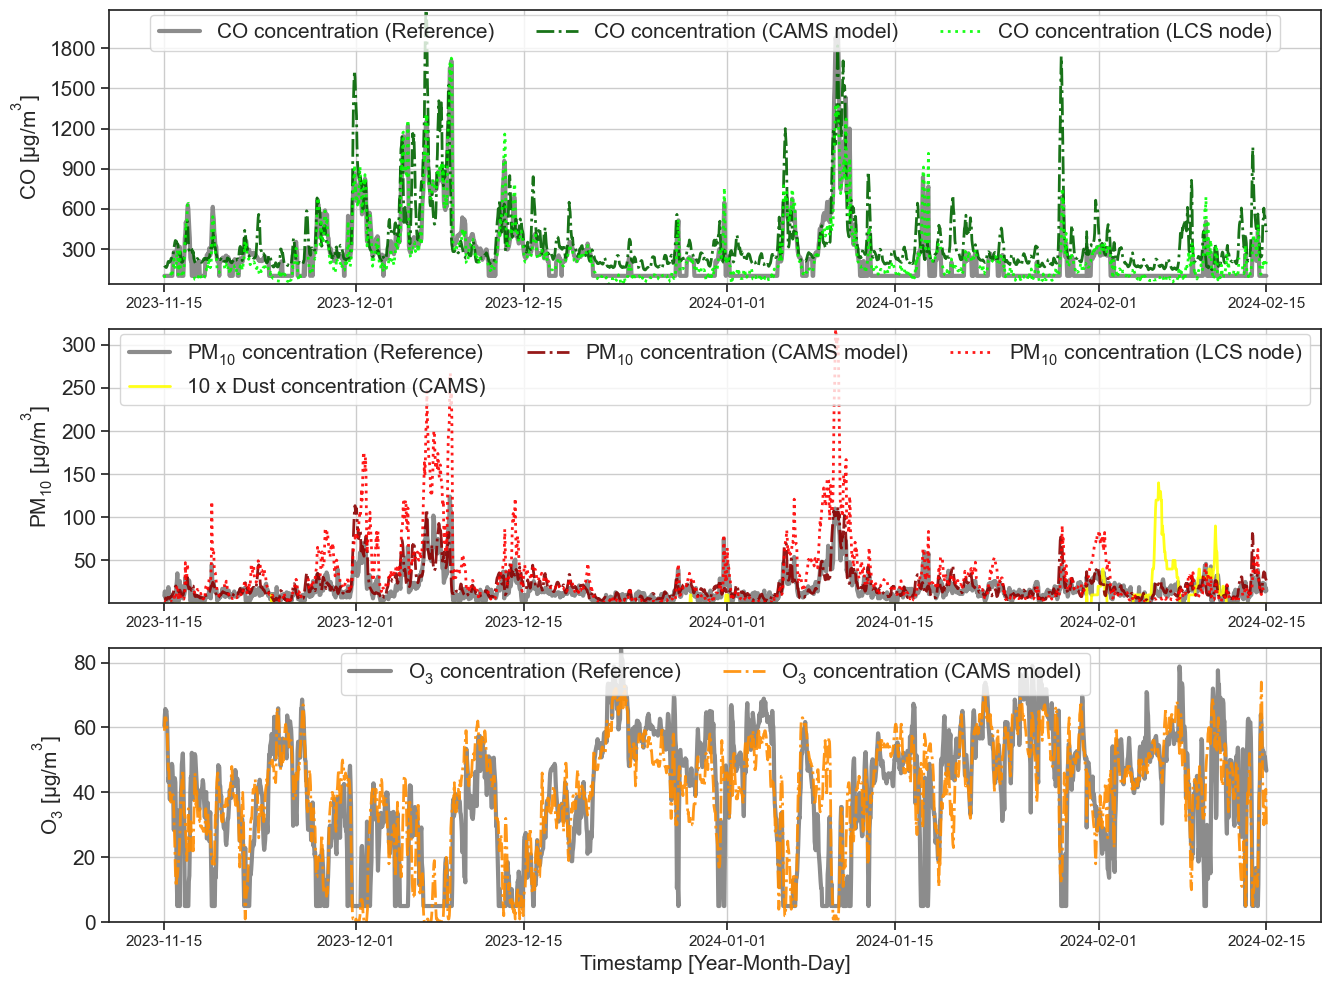

In [7]:
# Create a figure and a set of subplots with adjusted height
fig, axs = plt.subplots(3, 1, figsize=(14, 10))  # 4 rows, 1 column, reduced height

# Define the y-axis limits for CO
y_min = min(df['CO [ug/m3]'].min(), df['carbon_monoxide (μg/m³)'].min(), df['CO'].min())
y_max = max(df['CO [ug/m3]'].max(), df['carbon_monoxide (μg/m³)'].max(), df['CO'].max())

# First subplot
axs[0].plot(df['GMT'], df['CO [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='CO concentration (Reference)')
axs[0].plot(df['GMT'], df['carbon_monoxide (μg/m³)'], color="darkgreen", linestyle="dashdot", linewidth=2, alpha=0.9, label='CO concentration (CAMS model)')
axs[0].plot(df['GMT'], df['CO'], color="lime", linestyle="dotted", linewidth=2, alpha=0.9,  label='CO concentration (LCS node)')
axs[0].set_ylabel('CO [$µg/m^3$]', fontsize=15)
axs[0].grid(True)
axs[0].set_ylim(y_min, y_max)
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(300))  # Adjust interval as needed
axs[0].tick_params(axis='y', labelsize=15)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for PM10
y_min = min(df['PM10 [ug/m3]'].min(), df['pm10 (μg/m³)'].min(), df['PM_10_y'].min())
y_max = max(df['PM10 [ug/m3]'].max(), df['pm10 (μg/m³)'].max(), df['PM_10_y'].max())

# Second subplot
axs[1].plot(df['GMT'], df['PM10 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$PM_{10}$ concentration (Reference)')
axs[1].plot(df['GMT'], df['dust (μg/m³)']*10, color="yellow", linestyle="solid", linewidth=2, alpha=0.9, label='10 x Dust concentration (CAMS)')
axs[1].plot(df['GMT'], df['pm10 (μg/m³)'], color="darkred", linestyle="dashdot", linewidth=2, alpha=0.9, label='$PM_{10}$ concentration (CAMS model)')
axs[1].plot(df['GMT'], df['PM_10_y'], color="red", linestyle="dotted", linewidth=2, alpha=0.9,  label='$PM_{10}$ concentration (LCS node)')
axs[1].set_ylabel('$PM_{10}$ [$µg/m^3$]', fontsize=15)
axs[1].grid(True)
axs[1].set_ylim(y_min, y_max)
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(50))  # Adjust interval as needed
axs[1].tick_params(axis='y', labelsize=15)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for O3
y_min = min(df['O3 [ug/m3]'].min(), df['ozone (μg/m³)'].min())
y_max = max(df['O3 [ug/m3]'].max(), df['ozone (μg/m³)'].max())

# Fourth subplot
axs[2].plot(df['GMT'], df['O3 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$O_3$ concentration (Reference)')
axs[2].plot(df['GMT'], df['ozone (μg/m³)'], color="darkorange", linestyle="dashdot", linewidth=2, alpha=0.9, label='$O_3$ concentration (CAMS model)')
axs[2].set_ylabel('$O_3$ [$µg/m^3$]', fontsize=15)
axs[2].set_xlabel('Timestamp [Year-Month-Day]', fontsize=15)
axs[2].grid(True)
axs[2].set_ylim(y_min, y_max)
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(20))  # Adjust interval as needed
axs[2].tick_params(axis='y', labelsize=15)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
print("Columns in DataFrame (df):", df.columns)

Columns in DataFrame (df): Index(['GMT', 'T', 'RH', 'p', 'PM_1_x', 'PM_2.5', 'PM_10_x', 'PM_1_y', 'PM_2',
       'PM_10_y', 'CO', 'WSPE [m/s]', 'WDIR [deg]', 'HUMI [%]', 'PRES [hPa]',
       'TEMP [°C]', 'PM10 [ug/m3]', 'PM25 [ug/m3]', 'PM01 [ug/m3]',
       'O3 [ug/m3]', 'SO2 [ug/m3]', 'NO [ug/m3]', 'NO2 [ug/m3]', 'CO [ug/m3]',
       'pm10 (μg/m³)', 'pm2_5 (μg/m³)', 'carbon_monoxide (μg/m³)',
       'nitrogen_dioxide (μg/m³)', 'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)',
       'dust (μg/m³)', 'uv_index ()', 'ammonia (μg/m³)'],
      dtype='object')


In [9]:
# Přejmenování sloupců
df.rename(columns={
    'PM_1_y': 'LCS node $PM_1$',
    'PM_2': 'LCS node $PM_{2.5}$',
    'PM_10_y': 'LCS node $PM_{10}$',
    'CO': 'LCS node CO',
    'PM10 [ug/m3]': 'Reference $PM_{10}$',
    'PM25 [ug/m3]': 'Reference $PM_{2.5}$',
    'PM01 [ug/m3]': 'Reference $PM_1$',
    'O3 [ug/m3]': 'Reference $O_3$',
    'NO2 [ug/m3]': 'Reference $NO_2$',
    'CO [ug/m3]': 'Reference CO',
    'pm10 (μg/m³)': 'CAMS model $PM_{10}$',
    'pm2_5 (μg/m³)': 'CAMS model $PM_{2.5}$',
    'carbon_monoxide (μg/m³)': 'CAMS model CO',
    'nitrogen_dioxide (μg/m³)': 'CAMS model $NO_2$',
    'ozone (μg/m³)': 'CAMS model $O_3$'}, inplace=True)

# Zobrazení přejmenovaných sloupců
print(df.columns)

Index(['GMT', 'T', 'RH', 'p', 'PM_1_x', 'PM_2.5', 'PM_10_x', 'LCS node $PM_1$',
       'LCS node $PM_{2.5}$', 'LCS node $PM_{10}$', 'LCS node CO',
       'WSPE [m/s]', 'WDIR [deg]', 'HUMI [%]', 'PRES [hPa]', 'TEMP [°C]',
       'Reference $PM_{10}$', 'Reference $PM_{2.5}$', 'Reference $PM_1$',
       'Reference $O_3$', 'SO2 [ug/m3]', 'NO [ug/m3]', 'Reference $NO_2$',
       'Reference CO', 'CAMS model $PM_{10}$', 'CAMS model $PM_{2.5}$',
       'CAMS model CO', 'CAMS model $NO_2$', 'sulphur_dioxide (μg/m³)',
       'CAMS model $O_3$', 'dust (μg/m³)', 'uv_index ()', 'ammonia (μg/m³)'],
      dtype='object')


In [10]:
# Načení ukázkových dat
df_kor = df[['Reference $PM_{10}$', 'Reference CO', 'Reference $O_3$', 'Reference $NO_2$']]

print("Columns in DataFrame (df_kor):", df_kor.columns)

Columns in DataFrame (df_kor): Index(['Reference $PM_{10}$', 'Reference CO', 'Reference $O_3$',
       'Reference $NO_2$'],
      dtype='object')


In [11]:
print(df_kor.dtypes)
#corr=df_kor.corr(method='pearson', min_periods=None)
corr=df_kor.corr(method='pearson', min_periods=None)

Reference $PM_{10}$    float64
Reference CO           float64
Reference $O_3$        float64
Reference $NO_2$       float64
dtype: object


In [12]:
print(corr)

                     Reference $PM_{10}$  Reference CO  Reference $O_3$  \
Reference $PM_{10}$             1.000000      0.854020        -0.611006   
Reference CO                    0.854020      1.000000        -0.731479   
Reference $O_3$                -0.611006     -0.731479         1.000000   
Reference $NO_2$                0.792110      0.829943        -0.784846   

                     Reference $NO_2$  
Reference $PM_{10}$          0.792110  
Reference CO                 0.829943  
Reference $O_3$             -0.784846  
Reference $NO_2$             1.000000  


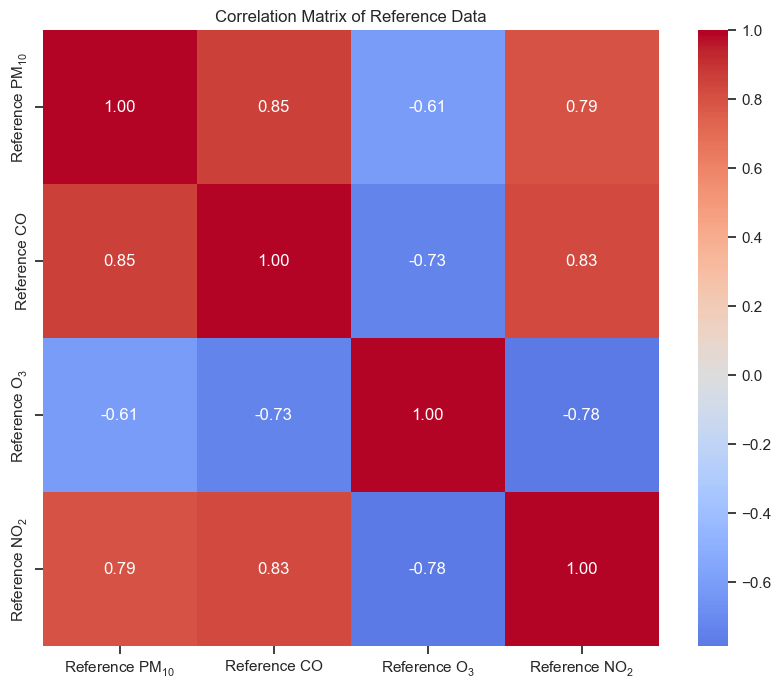

In [13]:
# Vykreslení korelační matice
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Reference Data')
plt.show()

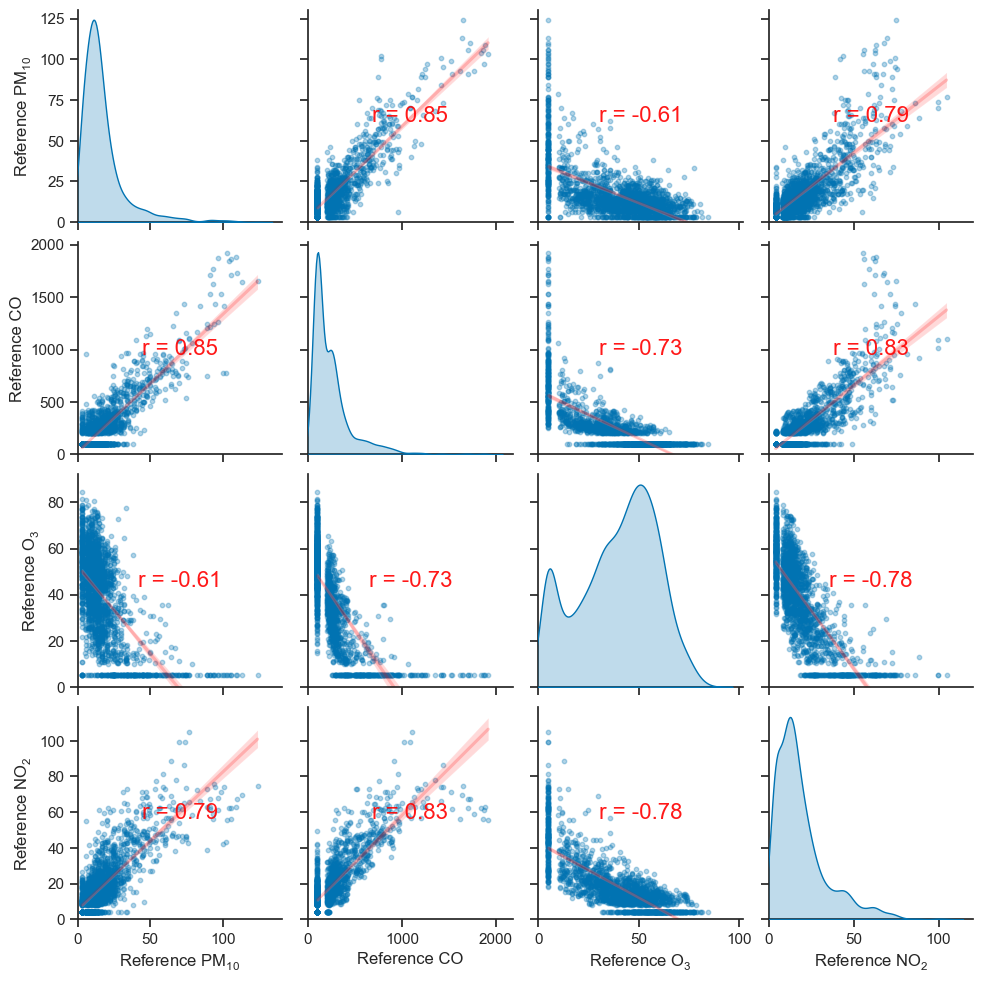

In [14]:
# Sample DataFrame
# df_kor = pd.read_csv('your_data.csv')  # Load your data here

# Compute the correlation matrix
corr_matrix = df_kor.corr()

# Function to annotate correlation coefficients
def annotate_corr(x, y, **kwargs):
    ax = plt.gca()
    col1 = x.name
    col2 = y.name
    r = corr_matrix.loc[col1, col2]
    ax.annotate(f'r = {r:.2f}', xy=(.5, .5), xycoords=ax.transAxes, ha='center', va='center', fontsize=16, color='red', alpha=0.9)

# Create pairplot
kg = sns.pairplot(df_kor, diag_kind="kde", kind="reg",
                  plot_kws={'line_kws': {'color': 'red', 'alpha': 0.2}, 'scatter_kws': {'alpha': 0.3, 's': 10}})

# Annotate the upper and lower triangles with correlation coefficients
kg.map_upper(annotate_corr)
kg.map_lower(annotate_corr)

# Set axis limits for all plots
for ax in kg.axes.flatten():
    ax.set_ylim(ymin=0)  # Change 0 to your desired minimum y-axis limit
    ax.set_xlim(xmin=0)  # Change 0 to your desired minimum x-axis limit

plt.show()

In [15]:
# Round the temperature and humidity values to the nearest integer
df['TEMP [°C]'] = df['TEMP [°C]'].round(0)
df["HUMI [%]"] = df["HUMI [%]"].round(0)

# Bin the rounded temperature and humidity values
df['Temperature [°C]'] = pd.cut(df['TEMP [°C]'], bins=10)
df["Humidity [%]"] = pd.cut(df["HUMI [%]"], bins=10)

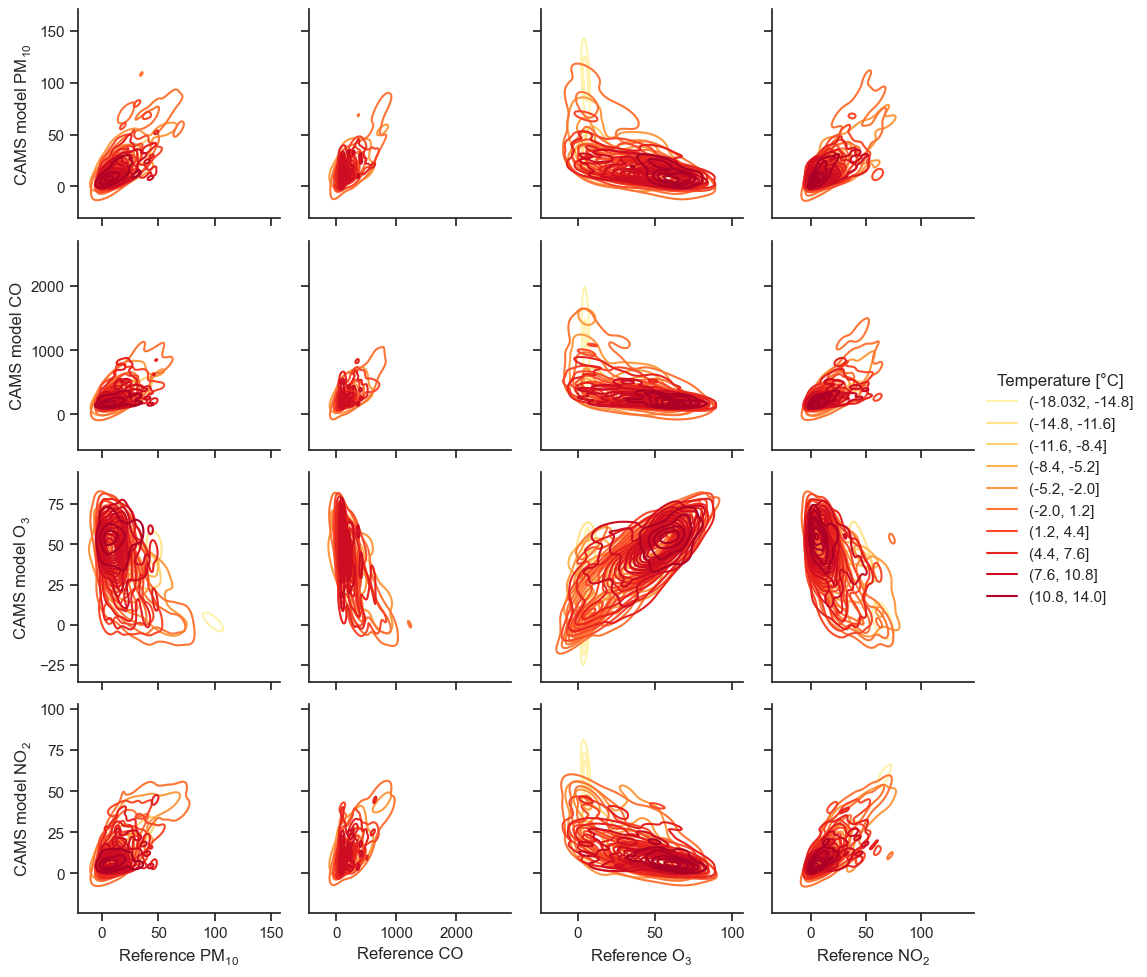

In [16]:
# Vykreslení párového grafu s vybranými řádky/sloupci pomocí PairGrid
g = sns.PairGrid(
    df, hue='Temperature [°C]', palette="YlOrRd",
    x_vars=['Reference $PM_{10}$','Reference CO','Reference $O_3$','Reference $NO_2$'],
    y_vars=['CAMS model $PM_{10}$','CAMS model CO','CAMS model $O_3$','CAMS model $NO_2$']
)

g.map(sns.kdeplot)
# g.map_upper(sns.scatterplot# )
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
g.add_legend()
plt.show()

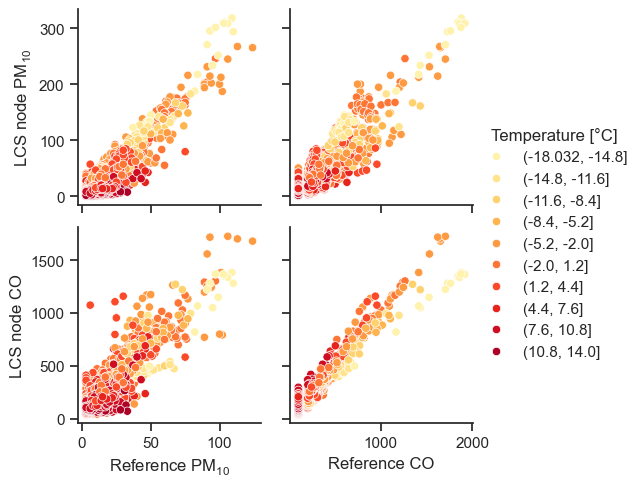

In [17]:
# Vykreslení párového grafu s vybranými řádky/sloupci pomocí PairGrid
kor_g = sns.PairGrid(
    df, hue='Temperature [°C]', palette="YlOrRd",
    x_vars=['Reference $PM_{10}$','Reference CO'],
    y_vars=['LCS node $PM_{10}$', 'LCS node CO']
)

kor_g.map(sns.scatterplot)
# kor_g.map_upper(sns.scatterplot# )
# kor_g.map_lower(sns.kdeplot)
# kor_g.map_diag(sns.kdeplot)
kor_g.add_legend()
plt.show()

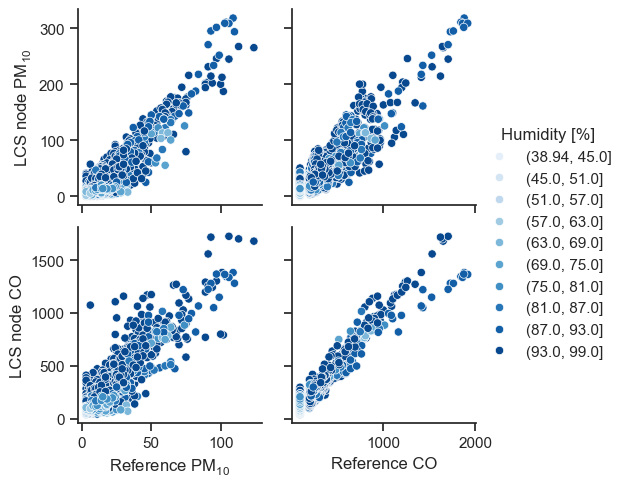

In [18]:
# Vykreslení párového grafu s vybranými řádky/sloupci pomocí PairGrid
kor_g = sns.PairGrid(
    df, hue='Humidity [%]', palette="Blues",
    x_vars=['Reference $PM_{10}$','Reference CO'],
    y_vars=['LCS node $PM_{10}$','LCS node CO']
)

kor_g.map(sns.scatterplot)
# kor_g.map_upper(sns.scatterplot# )
# kor_g.map_lower(sns.kdeplot)
# kor_g.map_diag(sns.kdeplot)
kor_g.add_legend()
plt.show()